# Jovian Analysis - Consolidated Notebook

**Unified notebook for Jovian calldata footprint gas scalar analysis**

## Features
- ✅ **Multi-chain support**: Base, OP Mainnet etc.
- ✅ **Flexible sampling**: Top percentile or random sampling
- ✅ **Date range analysis**: Analyze multiple dates with per-date breakdown
- ✅ **Dynamic gas limits**: Uses per-chain historical CSV data
- ✅ **Compression analysis**: FastLZ compression ratios and DA efficiency
- ✅ **Enhanced visualizations**: Comprehensive charts with recommendations
- ✅ **Caching system**: Local parquet files for performance
- ✅ **Optimal recommendations**: Data-driven scalar suggestions

## Quick Start
1. **Configure parameters** in the cell below
2. **Run all cells** to perform analysis
3. **Review results** in the generated visualizations

In [1]:
%load_ext autoreload
%autoreload 2

## Step 1: Setup and Imports

In [2]:
# Core imports
import sys
from pathlib import Path
import polars as pl
from datetime import datetime, timedelta
from collections import Counter
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd

# Add parent directory to path
sys.path.append(str(Path.cwd().parent))

# Import Jovian modules
from jovian_src.chain_config import (
    get_chain_display_name
)
from jovian_src.constants import (
    DEFAULT_DA_FOOTPRINT_GAS_SCALARS
)
from jovian_src.clickhouse_fetcher import (
    fetch_top_percentile_blocks,
    fetch_random_sample_blocks
)
from jovian_src.analysis_functions import (
    perform_jovian_analysis,
    generate_jovian_recommendation
)
from jovian_src.visualization_jovian import (
    generate_all_visualizations,
    plot_block_metric_distribution
)

print("✅ Modules loaded successfully")
print(f"✅ Available scalars: {DEFAULT_DA_FOOTPRINT_GAS_SCALARS}")

✅ Modules loaded successfully
✅ Available scalars: [160, 400, 600, 800]


## Step 2: Configuration

**Edit these parameters to customize your analysis:**

In [3]:
# ============================================================================
# ANALYSIS CONFIGURATION - EDIT THESE PARAMETERS
# ============================================================================

# Chain selection
CHAIN = "unichain"  # Options: base, op

# Sampling method
SAMPLING_METHOD = "random"  # "top_percentile" or "random"
PERCENTILE = 99.0    # For top percentile (99 = top 1%)
NUM_BLOCKS = 100     # For random sampling - blocks per day
RANDOM_SEED = 42     # For reproducible random sampling
SAMPLE_FRACTION = 0.01  # For random sampling (1% = 0.01)

# Date range
START_DATE = "2025-04-29"
END_DATE = "2025-08-26"  # Inclusive
# START_DATETIME = datetime(2025, 9, 9, 20, 25, 18)  # utc
# END_DATETIME = datetime(2025, 9, 9, 20, 25, 37)    # utc
# START_DATE = START_DATETIME.strftime("%Y-%m-%d")
# END_DATE = END_DATETIME.strftime("%Y-%m-%d")

# Analysis parameters
DA_FOOTPRINT_GAS_SCALARS = DEFAULT_DA_FOOTPRINT_GAS_SCALARS  # [160, 400, 600, 800]
BLOCK_LIMIT = None   # None = all blocks for selected method
FORCE_REFRESH = False  # Set True to ignore cache and re-download

# Output settings
SAVE_RESULTS = True
SHOW_PLOTS = True

print("✅ Configuration loaded:")
print(f"   Chain: {CHAIN}")
print(f"   Method: {SAMPLING_METHOD}")
if SAMPLING_METHOD == "top_percentile":
    print(f"   Percentile: Top {100-PERCENTILE}%")
else:
    print(f"   Sample: {int(SAMPLE_FRACTION*100)}% random")
print(f"   Date range: {START_DATE} to {END_DATE}")

from jovian_src.clickhouse_fetcher import fetch_eip1559_elasticity
eip1559_elasticity = fetch_eip1559_elasticity(CHAIN)

✅ Configuration loaded:
   Chain: unichain
   Method: random
   Sample: 1% random
   Date range: 2025-04-29 to 2025-08-26
2025-09-18 20:12:41 [debug    ] connecting to OPLABS Clickhouse client... filename=client.py lineno=56 process=3750
2025-09-18 20:12:41 [info     ] loaded vault from .env file    filename=vault.py lineno=32 process=3750
2025-09-18 20:12:41 [debug    ] loaded vault: 28 items         filename=vault.py lineno=79 process=3750
2025-09-18 20:12:42 [debug    ] initialized OPLABS Clickhouse client. filename=client.py lineno=61 process=3750
⚠️  ClickHouse returned 0 for unichain, trying GitHub fallback...
✅ Fetched EIP-1559 elasticity for unichain: 6


## Step 3: Initialize Analysis Environment

In [4]:
# ============================================================================
# ENVIRONMENT SETUP
# ============================================================================

# Paths
CACHE_DIR = Path(".cache")
OUTPUT_DIR = Path(f"../results/{CHAIN}/jovian_analysis_{SAMPLING_METHOD}_{START_DATE}_{END_DATE}")

# Create output directory
if SAVE_RESULTS:
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    print(f"📁 Output directory: {OUTPUT_DIR}")

# Generate date list
start = datetime.strptime(START_DATE, "%Y-%m-%d")
end = datetime.strptime(END_DATE, "%Y-%m-%d")
DATES_TO_ANALYZE = [(start + timedelta(days=i)).strftime("%Y-%m-%d") 
                     for i in range((end - start).days + 1)]

# Cache configuration
def _method_key():
    """Generate cache key based on sampling method and parameters."""
    if SAMPLING_METHOD == "top_percentile":
        return f"top{PERCENTILE*100:.1f}pct_lim{BLOCK_LIMIT}"
    return f"rand_frac{SAMPLE_FRACTION}_seed{RANDOM_SEED}"

def _cache_path(date_str: str) -> Path:
    """Generate cache file path for a specific date."""
    return CACHE_DIR / CHAIN / _method_key() / f"{date_str}.parquet"

print(f"🔧 Cache method: {_method_key()}")
print(f"📅 Dates to analyze: {len(DATES_TO_ANALYZE)}")

📁 Output directory: ../results/unichain/jovian_analysis_random_2025-04-29_2025-08-26
🔧 Cache method: rand_frac0.01_seed42
📅 Dates to analyze: 120


## Step 4: Data Fetching and Caching

In [5]:
# ============================================================================
# DATA FETCHING WITH CACHING
# ============================================================================

print(f"📥 Fetching data for {CHAIN} using {SAMPLING_METHOD} method...")
print("=" * 60)

all_dataframes = []
fetch_summary = []
per_date_dataframes = {}

# Display method description
method_display = f"top {100-PERCENTILE}%" if SAMPLING_METHOD == "top_percentile" else f"{int(SAMPLE_FRACTION*100)}% random"
print(f"📊 Method: {method_display} blocks")

start_time = time.time()

for date in DATES_TO_ANALYZE:

    cache_file = _cache_path(date)

    # Show progress for shorter date ranges
    if len(DATES_TO_ANALYZE) <= 7:
        print(f"\n📅 {date}")
    
    # Check cache first
    if cache_file.exists() and not FORCE_REFRESH:
        df = pl.read_parquet(cache_file)
        if len(DATES_TO_ANALYZE) <= 7:
            print(f"   📦 Cache hit → {len(df):,} transactions")
    else:
        # Fetch from source
        cache_file.parent.mkdir(parents=True, exist_ok=True)
        
        try:
            if SAMPLING_METHOD == "top_percentile":
                df = fetch_top_percentile_blocks(
                    chain=CHAIN,
                    date=date,
                    percentile=PERCENTILE,
                    limit=BLOCK_LIMIT
                )
            else:
                df = fetch_random_sample_blocks(
                    chain=CHAIN,
                    date=date,
                    sample_fraction=SAMPLE_FRACTION,
                    seed=RANDOM_SEED,
                    # start_datetime=START_DATETIME,
                    # end_datetime=END_DATETIME
                )
            
            # Save to cache if we got data
            if not df.is_empty():
                df.write_parquet(cache_file)
                if len(DATES_TO_ANALYZE) <= 7:
                    print(f"   💾 Saved to cache → {len(df):,} transactions")
            
        except Exception as e:
            print(f"   ❌ Error fetching {date}: {e}")
            df = pl.DataFrame()
    
    # Process results
    if not df.is_empty():
        all_dataframes.append(df)
        per_date_dataframes[date] = df
        blocks = df['block_number'].n_unique()
        txs = len(df)
        fetch_summary.append({
            'date': date,
            'blocks': blocks,
            'transactions': txs,
            'df': df
        })
        if len(DATES_TO_ANALYZE) <= 7:
            print(f"   ✅ {blocks} blocks, {txs:,} transactions")
    else:
        if len(DATES_TO_ANALYZE) <= 7:
            print(f"   ⚠️  No data for {date}")

total_time = time.time() - start_time
print(f"\n📊 Fetching complete!")
print(f"   Total time: {total_time:.1f}s")
print(f"   Average per date: {total_time/len(DATES_TO_ANALYZE):.1f}s")

# Combine all data
if all_dataframes:
    combined_df = pl.concat(all_dataframes)
    print(f"\n✅ Data summary:")
    print(f"   Total dates with data: {len(fetch_summary)}")
    print(f"   Total blocks: {combined_df['block_number'].n_unique():,}")
    print(f"   Total transactions: {len(combined_df):,}")
    
    # Debug: Show detailed info about the data
    print(f"\n🔍 Debug - Combined DataFrame Info:")
    print(f"   Columns: {combined_df.columns}")
    print(f"   Shape: {combined_df.shape}")
    print(f"   Sample data:")
    print(combined_df.head(3))
    
    # Check for any issues
    if 'block_number' not in combined_df.columns:
        print(f"   ❌ ERROR: 'block_number' column missing!")
    if 'input' not in combined_df.columns:
        print(f"   ❌ ERROR: 'input' column missing!")
    if 'calldata_size' not in combined_df.columns:
        print(f"   ❌ ERROR: 'calldata_size' column missing!")
        
else:
    print("\n❌ No data retrieved. Please check your parameters.")
    combined_df = pl.DataFrame()

# Gas limits are now handled per-block in the analysis
if not combined_df.is_empty() and 'gas_limit' in combined_df.columns:
    gas_limits = combined_df['gas_limit'].unique().to_list()
    print(f"\n📊 Gas limits in data: {len(gas_limits)} unique values")
    print(f"   Min: {min(gas_limits):,}, Max: {max(gas_limits):,}")
    print(f"   Average: {combined_df['gas_limit'].mean():.0f}")
else:
    print(f"\n📊 Gas limits: Not available in data (will use default from config)")

📥 Fetching data for unichain using random method...
📊 Method: 1% random blocks

📊 Fetching complete!
   Total time: 299.3s
   Average per date: 2.5s

✅ Data summary:
   Total dates with data: 120
   Total blocks: 103,680
   Total transactions: 1,575,072

🔍 Debug - Combined DataFrame Info:
   Columns: ['block_number', 'transaction_index', 'input', 'calldata_size', 'block_total_calldata', 'block_total_gas_used', 'block_timestamp', 'base_fee_per_gas', 'gas_limit', 'transaction_type', 'chain', 'sampling_method']
   Shape: (1575072, 12)
   Sample data:
shape: (3, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬──────────┬───────────┐
│ block_num ┆ transacti ┆ input     ┆ calldata_ ┆ … ┆ gas_limit ┆ transacti ┆ chain    ┆ sampling_ │
│ ber       ┆ on_index  ┆ ---       ┆ size      ┆   ┆ ---       ┆ on_type   ┆ ---      ┆ method    │
│ ---       ┆ ---       ┆ str       ┆ ---       ┆   ┆ i64       ┆ ---       ┆ str      ┆ ---       │
│ i64       ┆ i64       ┆  

In [6]:
# print min and max block number
print(f"Min block number: {combined_df['block_number'].min()}")
print(f"Max block number: {combined_df['block_number'].max()}")


Min block number: 15136561
Max block number: 25504367


## Step 5: Jovian Analysis

In [7]:
# Analyze combined data with multiple calldata footprint gas scalars
if not combined_df.is_empty():
    print(f"📊 ANALYZING COMBINED DATA")
    print("=" * 60)
    print(f"Chain: {get_chain_display_name(CHAIN)}")
    print(f"Dates analyzed: {len(fetch_summary)}")
    print(f"Sampling method: {SAMPLING_METHOD}")
    
    # Gas limits are now handled per-block automatically
    if "gas_limit" in combined_df.columns:
        print(f"Gas limits: Per-block from blocks_v1 data")
    else:
        print(f"Gas limits: Using default from config")
    
    analysis_results = perform_jovian_analysis(
        df=combined_df,
        eip1559_elasticity=eip1559_elasticity,
        da_footprint_gas_scalars=DEFAULT_DA_FOOTPRINT_GAS_SCALARS,
        chain=CHAIN,
        sampling_method=SAMPLING_METHOD,
        start_date=START_DATE,
        end_date=END_DATE,
        show_progress=True
    )
    
    print("\n✅ Jovian analysis complete!")
else:
    print("❌ No data to analyze")
    analysis_results = {}

📊 ANALYZING COMBINED DATA
Chain: Unichain
Dates analyzed: 120
Sampling method: random
Gas limits: Per-block from blocks_v1 data

🚀 JOVIAN ANALYSIS SUMMARY
Chain: Unichain
Sampling Method: random
Date Range: 2025-04-29 → 2025-08-26
Latest Gas Limit: 30,000,000
Per-block Gas Limits: Average: 30,000,000.0, Median: 30,000,000.0, Min: 30,000,000, Max: 30,000,000
DA Footprint Gas Scalars: [160, 400, 600, 800]

📊 Analyzing Unichain with DA footprint gas scalar: 160
   Effective limits: Per-block (gas_limit / 160)
   Sampling method: random
🚀 Analyzing 103680 blocks with 10 workers...


Processing blocks: 100%|██████████| 103680/103680 [00:47<00:00, 2183.56it/s]


   📊 Collected 103680 valid block analyses out of 103680 blocks
   ✅ Blocks exceeding: 0/103680 (0.0%)
   📈 Avg utilization: 2.11%
   🗜️ Avg compression ratio: 2.31x

📊 Analyzing Unichain with DA footprint gas scalar: 400
   Effective limits: Per-block (gas_limit / 400)
   Sampling method: random
🚀 Analyzing 103680 blocks with 10 workers...


Processing blocks: 100%|██████████| 103680/103680 [00:48<00:00, 2139.53it/s]


   📊 Collected 103680 valid block analyses out of 103680 blocks
   ✅ Blocks exceeding: 4/103680 (0.0%)
   📈 Avg utilization: 5.27%
   🗜️ Avg compression ratio: 2.31x

📊 Analyzing Unichain with DA footprint gas scalar: 600
   Effective limits: Per-block (gas_limit / 600)
   Sampling method: random
🚀 Analyzing 103680 blocks with 10 workers...


Processing blocks: 100%|██████████| 103680/103680 [00:48<00:00, 2157.68it/s]


   📊 Collected 103680 valid block analyses out of 103680 blocks
   ✅ Blocks exceeding: 5/103680 (0.0%)
   📈 Avg utilization: 7.90%
   🗜️ Avg compression ratio: 2.31x

📊 Analyzing Unichain with DA footprint gas scalar: 800
   Effective limits: Per-block (gas_limit / 800)
   Sampling method: random
🚀 Analyzing 103680 blocks with 10 workers...


Processing blocks: 100%|██████████| 103680/103680 [00:49<00:00, 2106.01it/s]


   📊 Collected 103680 valid block analyses out of 103680 blocks
   ✅ Blocks exceeding: 9/103680 (0.0%)
   📈 Avg utilization: 10.54%
   🗜️ Avg compression ratio: 2.31x

✅ Jovian analysis complete!


## Step 6: View Results with Compression Metrics

In [8]:
# Display analysis results including compression metrics
if analysis_results:
    print(f"🚀 JOVIAN ANALYSIS RESULTS - {get_chain_display_name(CHAIN)}")
    print("=" * 60)
    
    for scalar in sorted(analysis_results.keys()):
        result = analysis_results[scalar]
        print(f"\n🔹 Calldata Footprint Gas Scalar: {scalar}")
        print(f"   Gas limit: {result.gas_limit:,} (most common from {len(result.gas_limits)} blocks)")
        print(f"   Effective limit: {result.gas_limit // scalar:,} bytes")
        print(f"   Blocks exceeding: {result.blocks_exceeding}/{result.total_blocks} ({result.percentage_exceeding:.2f}%)")
        print(f"   Avg utilization: {result.avg_utilization:.2%}")
        print(f"   Max utilization: {result.max_utilization:.2%}")

        # ⛽ DA footprint vs *block gas used* (as % of gas used)
        if getattr(result, "blocks_with_gas_used", 0) > 0:
            mean_pct   = result.avg_util_vs_gas_used * 100
            median_pct = result.median_util_vs_gas_used * 100
            p95_pct    = result.p95_util_vs_gas_used * 100

            over_cnt_measured = int(round(result.share_over_1_vs_used * result.blocks_with_gas_used))
            over_pct_measured = result.share_over_1_vs_used * 100

            # Optional: express as share of ALL blocks too (matches the “Blocks exceeding” style)
            over_pct_all = (over_cnt_measured / result.total_blocks * 100) if result.total_blocks else 0

            print(f"\n   ⛽ DA footprint vs Block Gas Used:")
            print(f"      mean:   {mean_pct:.1f}%")
            print(f"      median: {median_pct:.1f}%   |   p95: {p95_pct:.1f}%")
            print(f"      Blocks over gas-used budget (>100%): "
                f"{over_cnt_measured}/{result.blocks_with_gas_used} ({over_pct_measured:.1f}%) ")
        else:
            print("\n   ⛽ DA footprint vs Block Gas Used: n/a (no blocks had block_gas_used)")
        
        # Show compression metrics
        if result.compression_metrics:
            print(f"\n   📊 Compression Metrics:")
            print(f"      Avg compression ratio: {result.compression_metrics.get('avg_compression_ratio', 0):.2f}x")
            print(f"      Median compression: {result.compression_metrics.get('median_compression_ratio', 0):.2f}x")
            print(f"      DA efficiency: {result.compression_metrics.get('avg_da_efficiency', 0):.1%}")
        
        if result.blocks_exceeding > 0:
            print(f"   Avg excess: {result.avg_excess_percentage:.1f}%")
            print(f"   Max excess: {result.max_excess_percentage:.1f}%")




🚀 JOVIAN ANALYSIS RESULTS - Unichain

🔹 Calldata Footprint Gas Scalar: 160
   Gas limit: 30,000,000 (most common from 103680 blocks)
   Effective limit: 187,500 bytes
   Blocks exceeding: 0/103680 (0.00%)
   Avg utilization: 2.11%
   Max utilization: 69.28%

   ⛽ DA footprint vs Block Gas Used:
      mean:   20.4%
      median: 19.6%   |   p95: 39.7%
      Blocks over gas-used budget (>100%): 1/103680 (0.0%) 

   📊 Compression Metrics:
      Avg compression ratio: 2.31x
      Median compression: 1.89x
      DA efficiency: 85.9%

🔹 Calldata Footprint Gas Scalar: 400
   Gas limit: 30,000,000 (most common from 103680 blocks)
   Effective limit: 75,000 bytes
   Blocks exceeding: 4/103680 (0.00%)
   Avg utilization: 5.27%
   Max utilization: 173.20%

   ⛽ DA footprint vs Block Gas Used:
      mean:   50.9%
      median: 48.9%   |   p95: 99.3%
      Blocks over gas-used budget (>100%): 4897/103680 (4.7%) 

   📊 Compression Metrics:
      Avg compression ratio: 2.31x
      Median compression:

## Step 7: Generate Recommendations

In [9]:
print(f"\n🎯 RECOMMENDATION - {get_chain_display_name(CHAIN)}")
print("=" * 60)

rec = generate_jovian_recommendation(
    results=analysis_results,            
    chain=CHAIN,
    start_date=START_DATE,
    end_date=END_DATE,
    target_excess_rate=0.01
)

for opt in rec["all_options"]:
    s = opt["da_footprint_gas_scalar"]
    tick = "✅" if opt["blocks_exceeding_pct"] <= 1 else ("⚠️" if opt["blocks_exceeding_pct"] <= 5 else "❌")

    # Avg compression from recommendation dict
    avg_comp = opt.get("avg_compression_ratio", 0.0)

    # Median compression from analysis_results (no lib changes needed)
    median_comp = 0.0
    if s in analysis_results and analysis_results[s].compression_metrics:
        median_comp = analysis_results[s].compression_metrics.get("median_compression_ratio", 0.0)

    # DA footprint > gas used share (only if measured)
    measured = opt.get("measured_blocks_gas_used", 0) or 0
    over_pct = opt.get("over_gas_used_pct", None)
    over_str = (
        f" | DA footprint > block gas used: {over_pct:.2f}% of {measured:,} blocks"
        if (over_pct is not None and measured > 0) else ""
    )

    print(
        f"{tick} Scalar {s}: {opt['blocks_exceeding_pct']:.2f}% exceeds gas limit, {opt['assessment']} | "
        f"avg comp {avg_comp:.2f}x (median {median_comp:.2f}x){over_str}"
    )



🎯 RECOMMENDATION - Unichain
✅ Scalar 160: 0.00% exceeds gas limit, Very Conservative | avg comp 2.31x (median 1.89x) | DA footprint > block gas used: 0.00% of 103,680 blocks
✅ Scalar 400: 0.00% exceeds gas limit, Conservative | avg comp 2.31x (median 1.89x) | DA footprint > block gas used: 4.72% of 103,680 blocks
✅ Scalar 600: 0.00% exceeds gas limit, Conservative | avg comp 2.31x (median 1.89x) | DA footprint > block gas used: 32.97% of 103,680 blocks
✅ Scalar 800: 0.01% exceeds gas limit, Conservative | avg comp 2.31x (median 1.89x) | DA footprint > block gas used: 49.33% of 103,680 blocks


## Step 8: Generate Visualizations

📊 Generating enhanced visualizations for Unichain...
📊 Generating enhanced DA usage estimates histogram...
✅ Saved DA usage estimates histogram (3 plots: basic, limits, targets) to ../results/unichain/jovian_analysis_random_2025-04-29_2025-08-26/1_da_usage_estimates_histogram.png
📊 Generating compression ratio histogram...
✅ Saved enhanced compression histogram to ../results/unichain/jovian_analysis_random_2025-04-29_2025-08-26/2_compression_histogram.png
📊 Generating exceeding limits analysis...
✅ Saved exceeding limits analysis to ../results/unichain/jovian_analysis_random_2025-04-29_2025-08-26/3_exceeding_limits_analysis.png
📊 Generating excess distribution...
✅ Saved excess distribution to ../results/unichain/jovian_analysis_random_2025-04-29_2025-08-26/4_excess_distribution.png
📊 Generating over-utilization analysis...
✅ Saved over-utilization analysis to ../results/unichain/jovian_analysis_random_2025-04-29_2025-08-26/5_over_utilization_analysis.png
📊 Generating scalar comparison

/Users/chuxinhuang/work/op-analytics/notebooks/adhoc/jovian_analysis/jovian_src/visualization_jovian.py:771: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


✅ Saved scalar comparison to ../results/unichain/jovian_analysis_random_2025-04-29_2025-08-26/6_scalar_comparison.png
📊 Generating comprehensive summary...


/Users/chuxinhuang/work/op-analytics/notebooks/adhoc/jovian_analysis/jovian_src/visualization_jovian.py:1174: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/chuxinhuang/work/op-analytics/notebooks/adhoc/jovian_analysis/jovian_src/visualization_jovian.py:1178: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


✅ Saved comprehensive summary to ../results/unichain/jovian_analysis_random_2025-04-29_2025-08-26/7_comprehensive_summary.png
✅ Generated 7 visualizations

✅ Generated 7 visualizations:
   1. Size estimates histogram (with vertical lines & zones)
   2. Compression ratio histogram (with percentiles & zones)
   3. Blocks exceeding limits analysis
   4. Excess distribution
   5. Over-utilization percentages
   6. Scalar comparison
   7. Comprehensive summary (NEW)

📁 Saved to: ../results/unichain/jovian_analysis_random_2025-04-29_2025-08-26


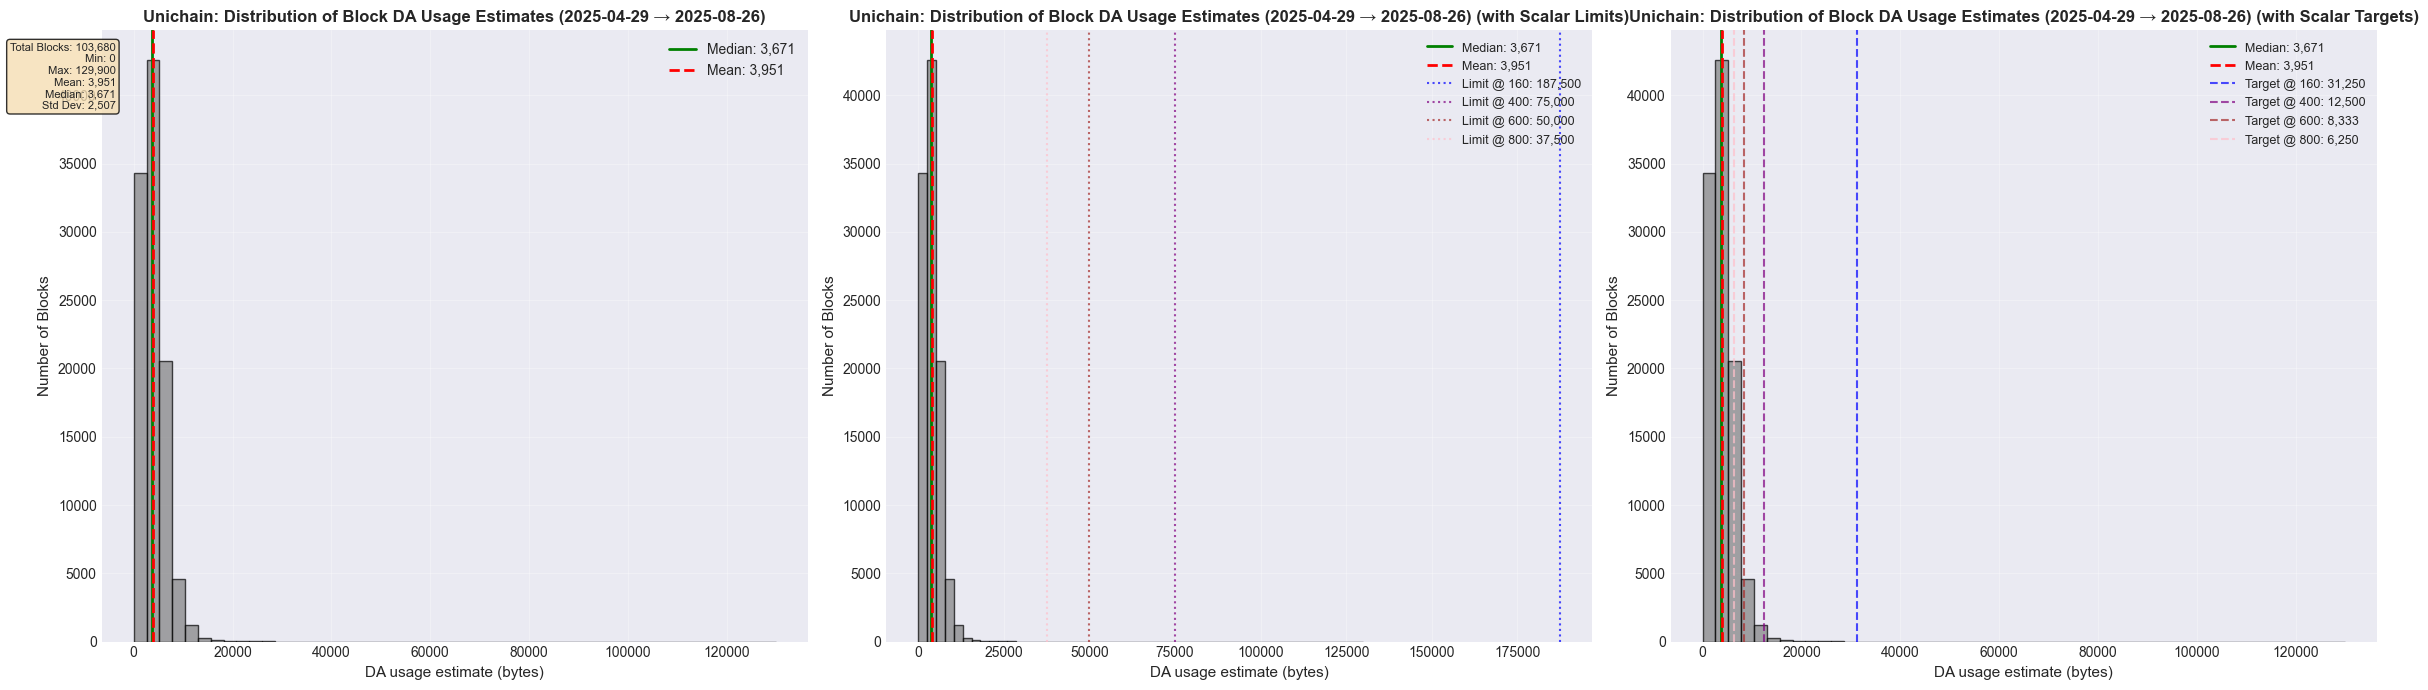

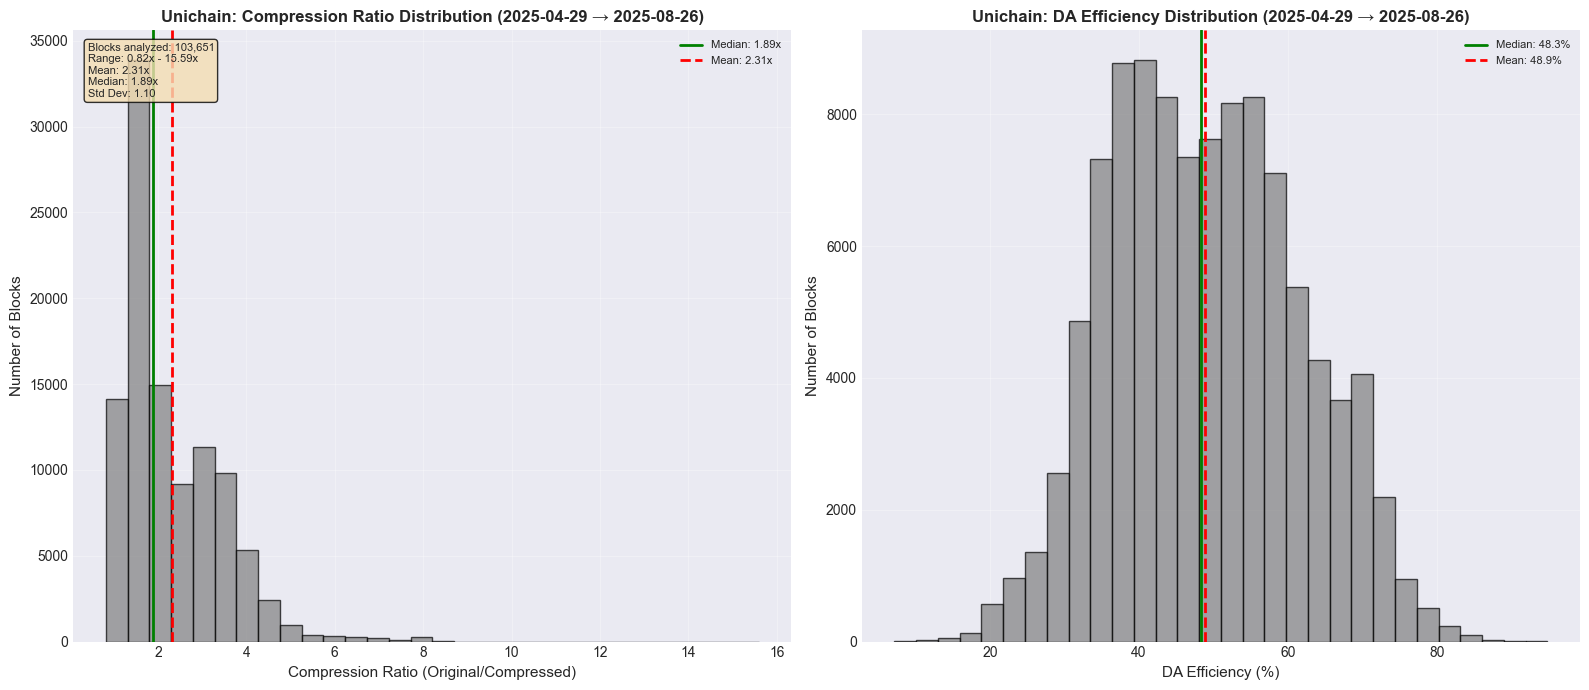

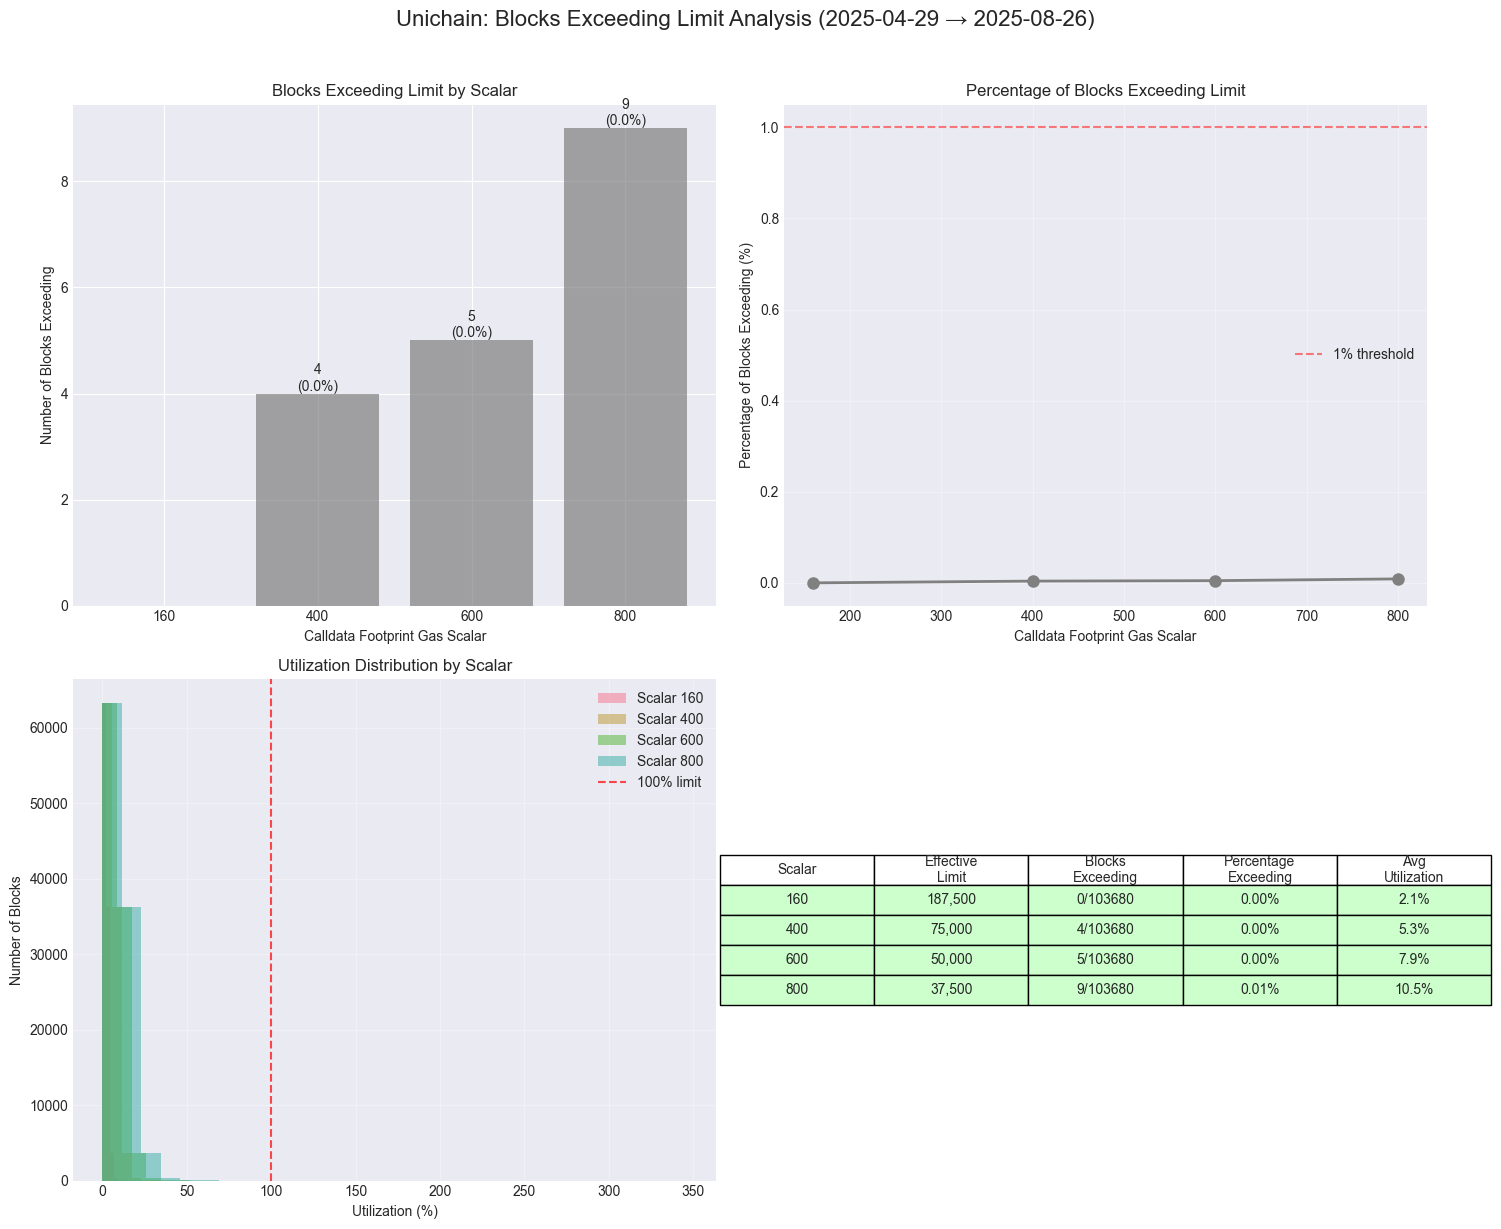

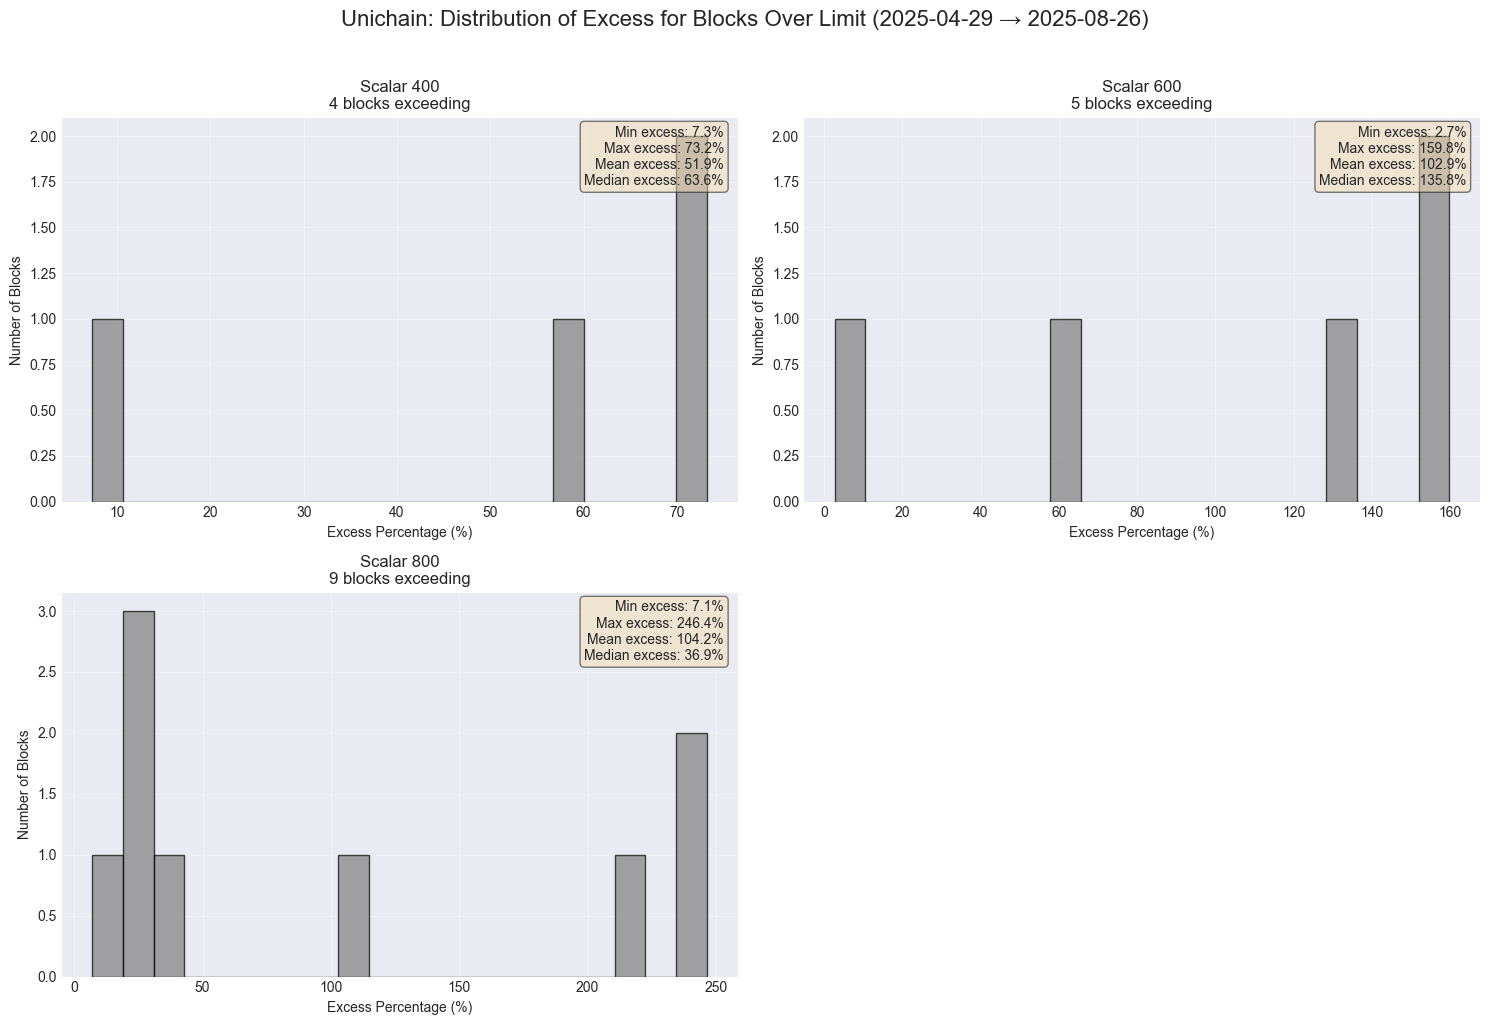

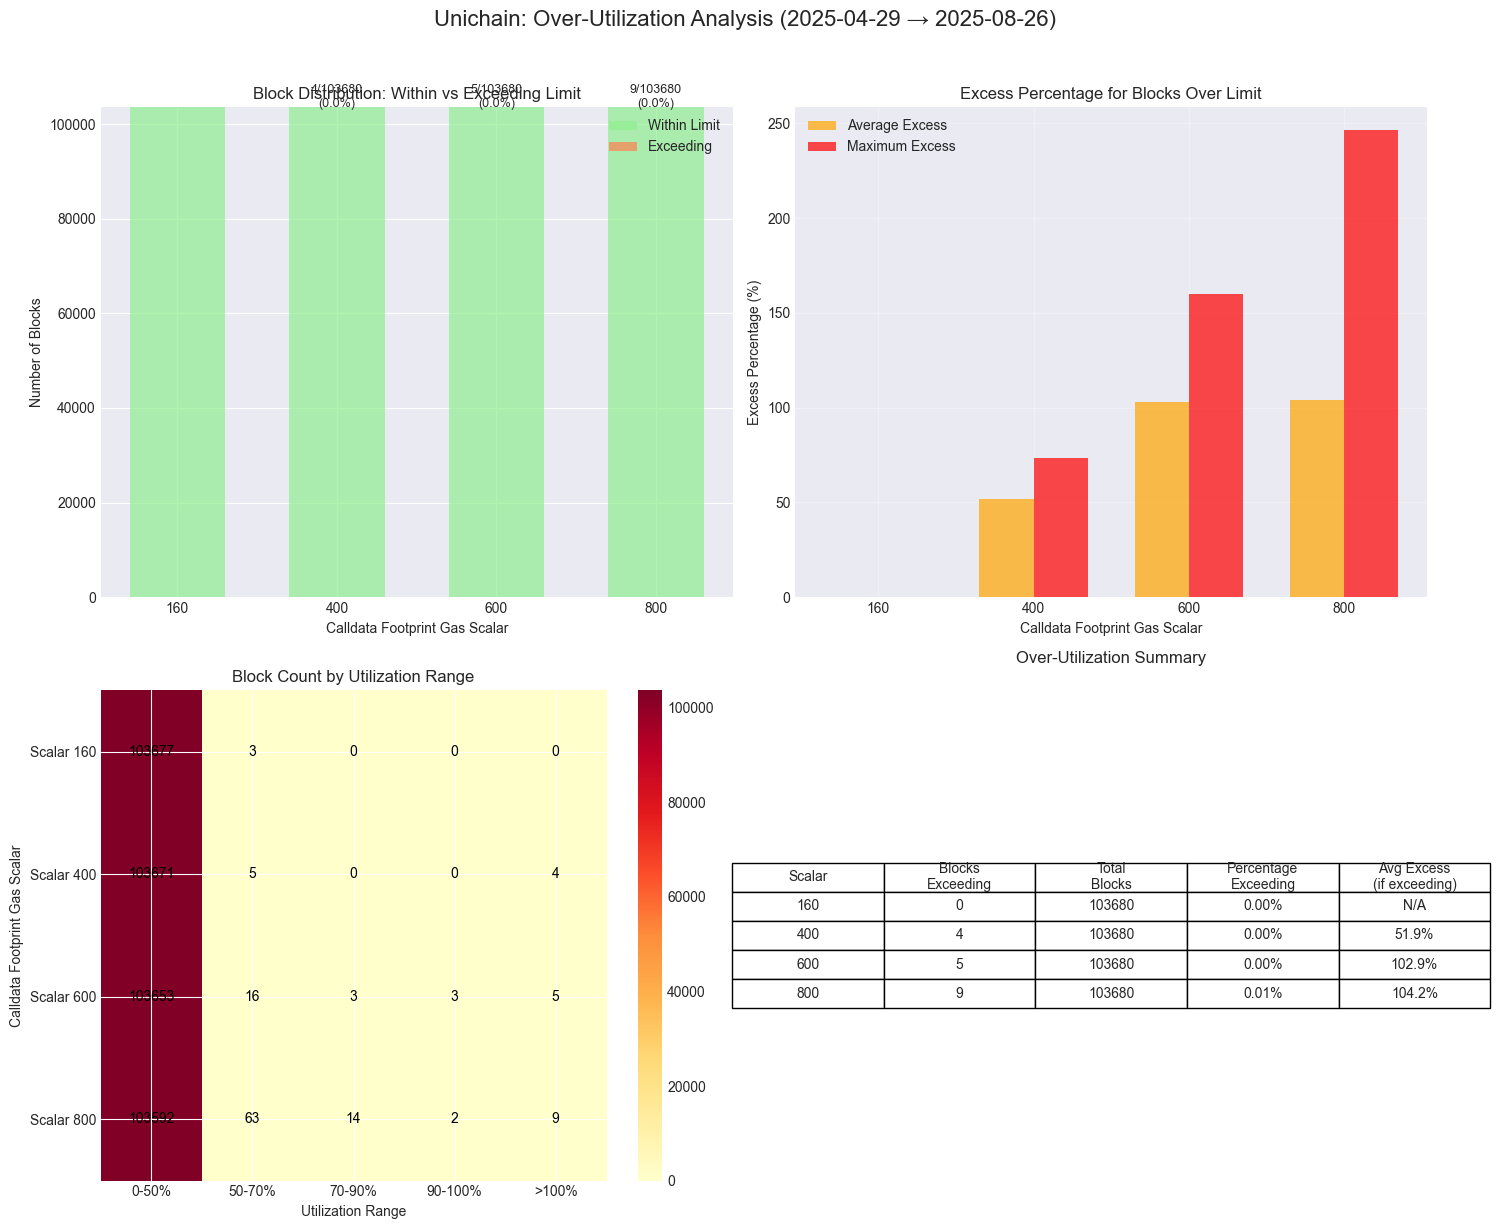

/Users/chuxinhuang/work/op-analytics/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


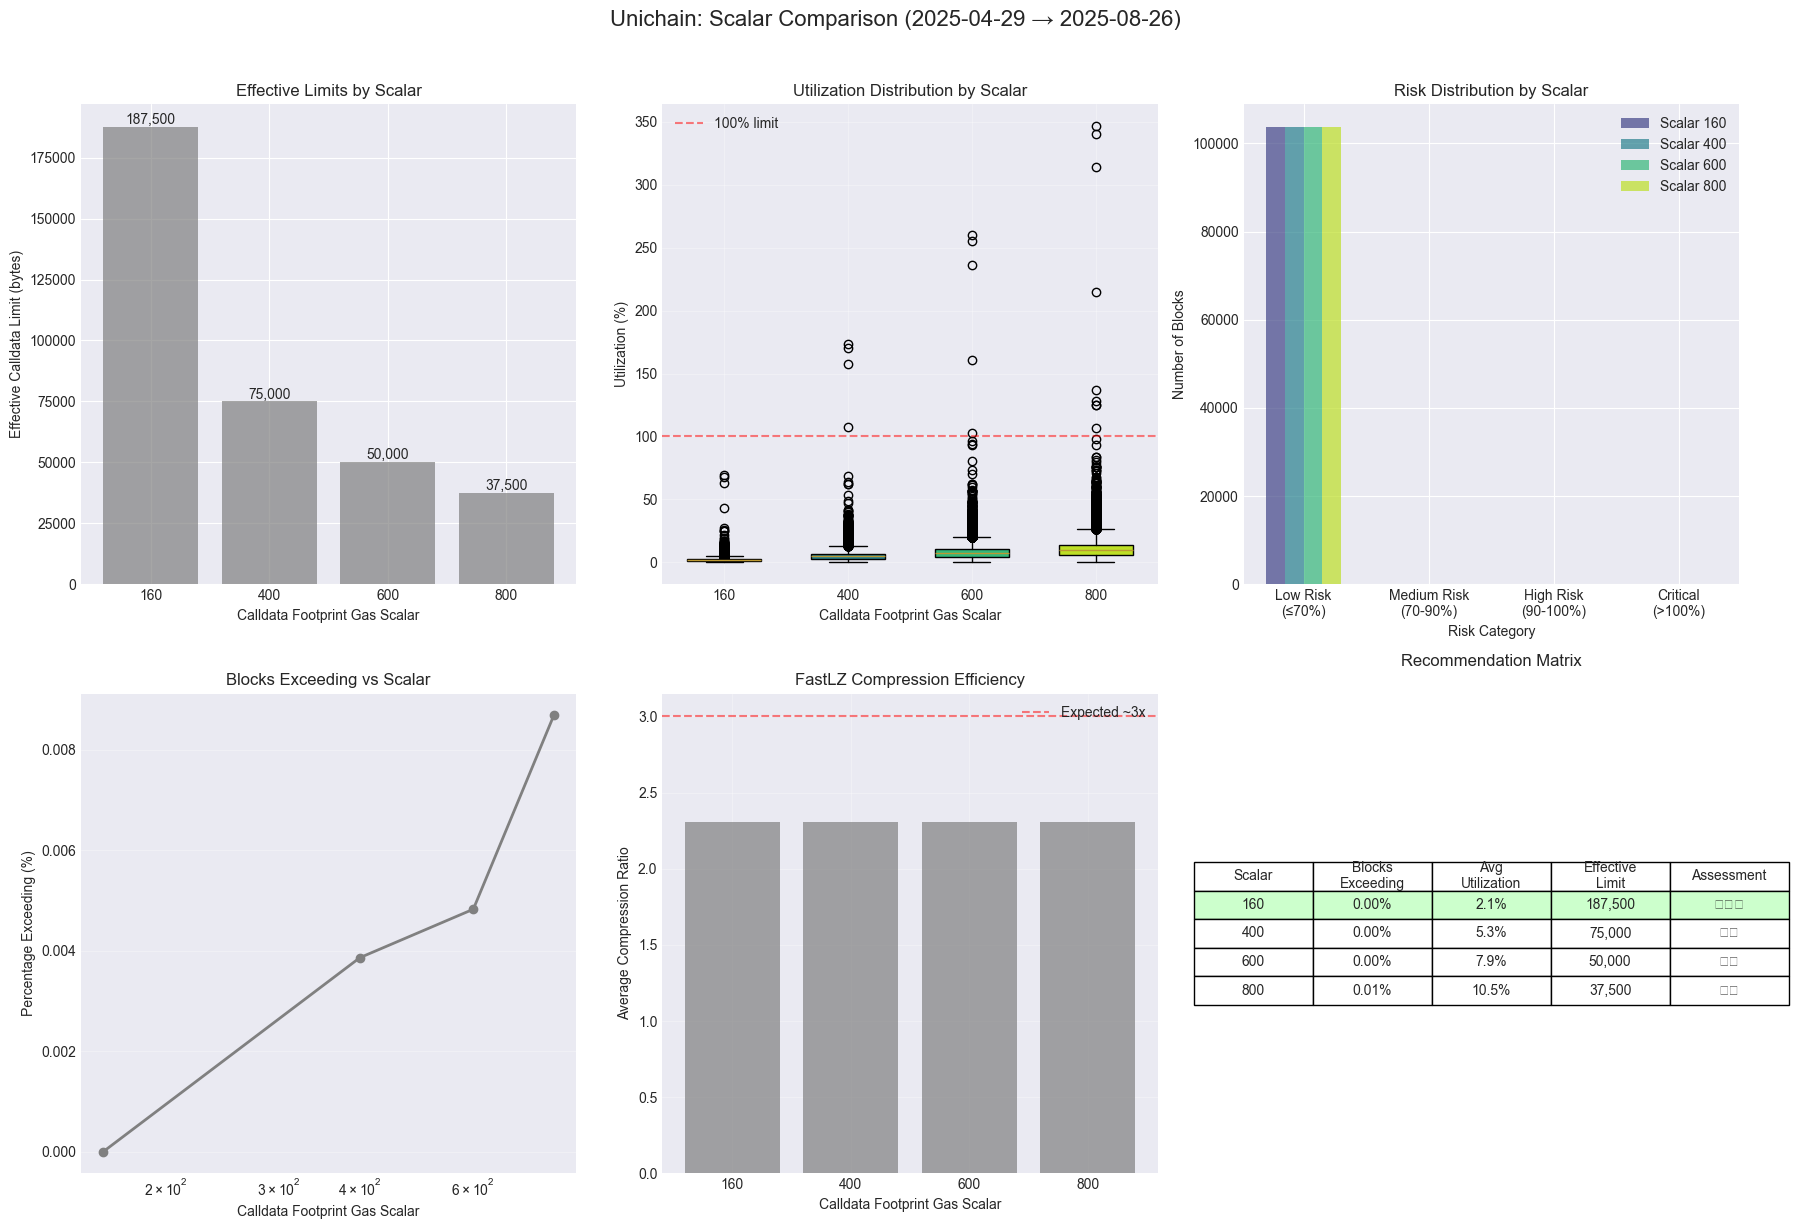

/Users/chuxinhuang/work/op-analytics/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


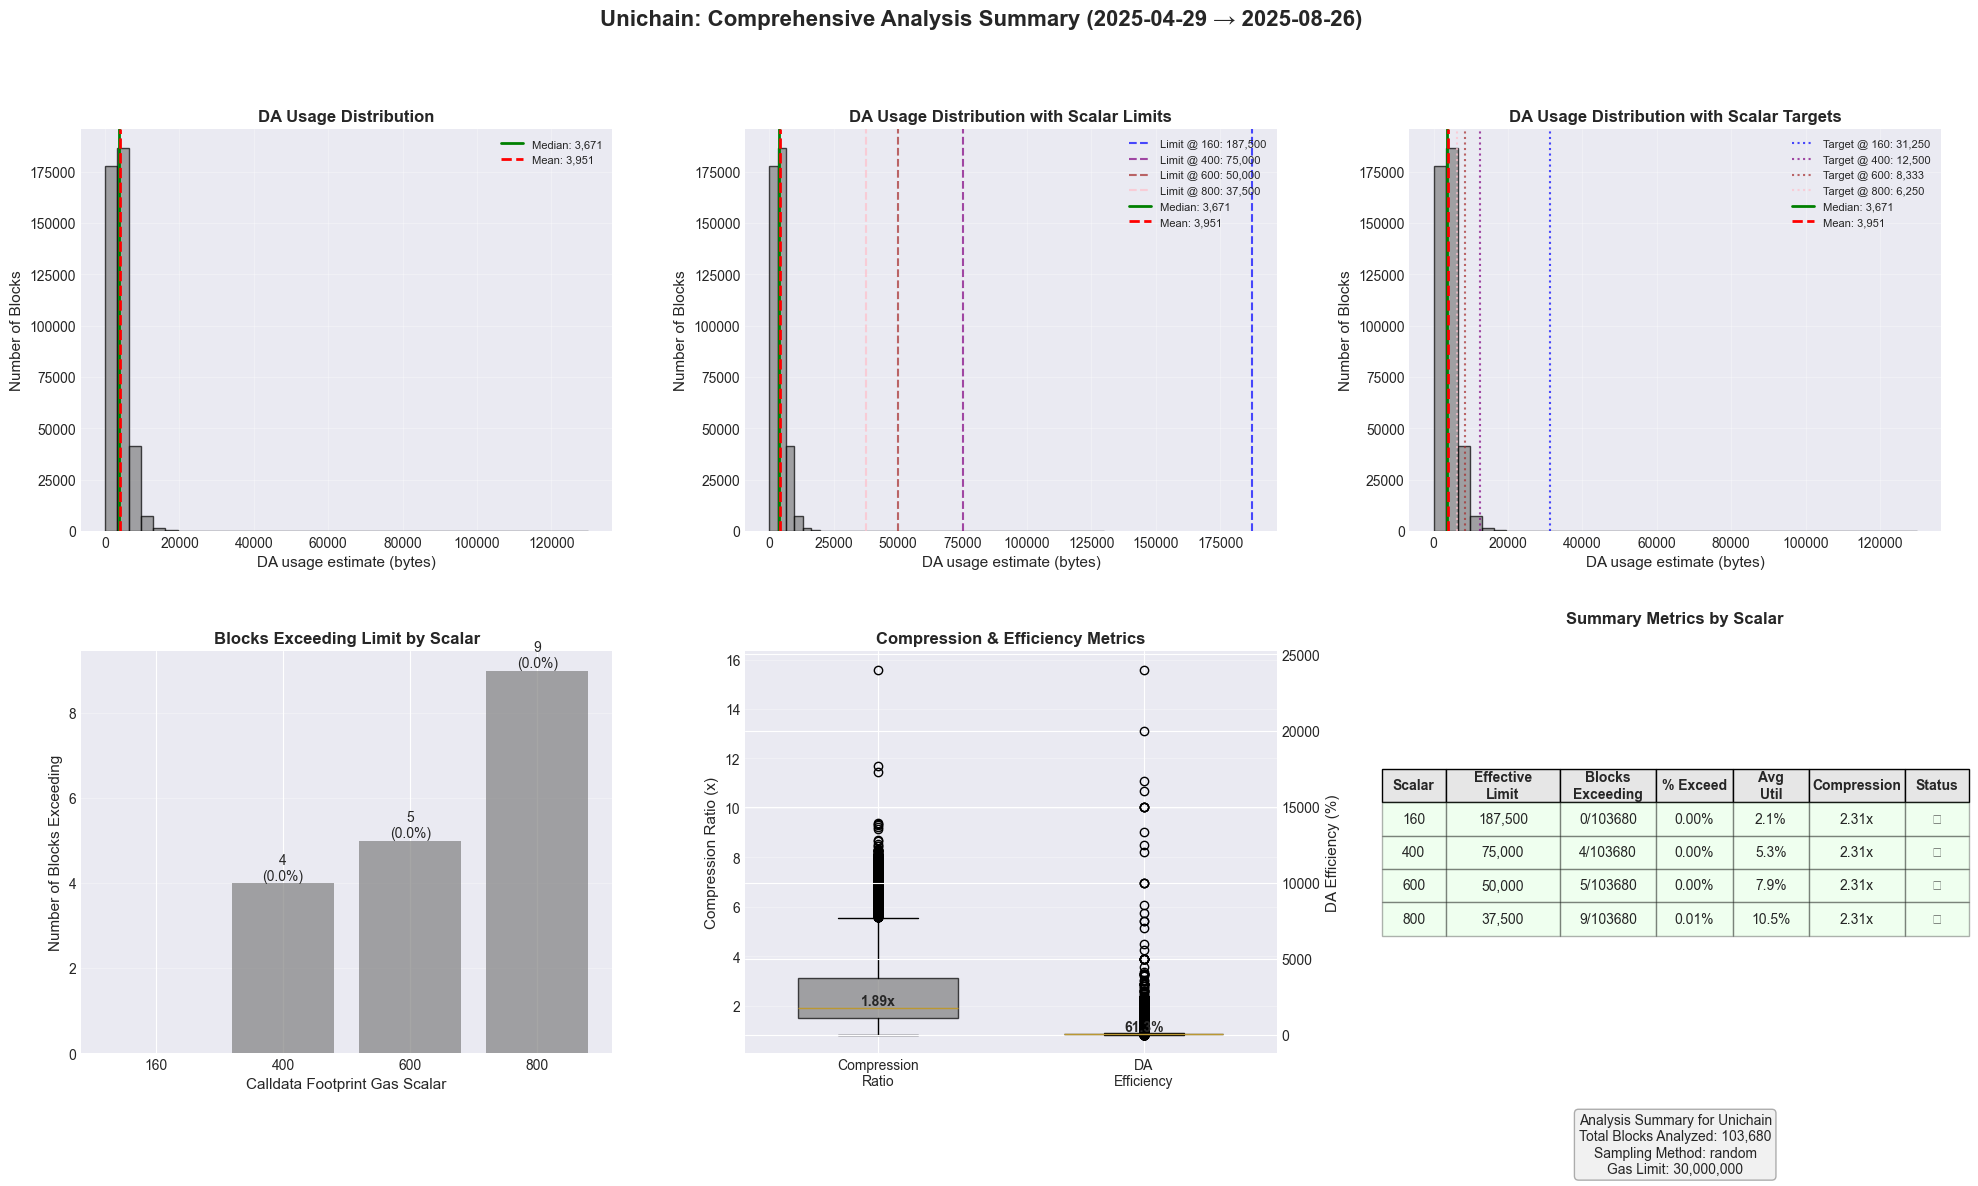

In [10]:
# Generate all Jovian visualizations with enhanced features
if analysis_results:
    print(f"📊 Generating enhanced visualizations for {get_chain_display_name(CHAIN)}...")
    
    # Generate all visualizations (includes new comprehensive summary)
    figures = generate_all_visualizations(
        results_by_scalar=analysis_results,
        eip1559_elasticity=eip1559_elasticity,
        output_dir=OUTPUT_DIR,
        chain=CHAIN,
        start_date=START_DATE,
        end_date=END_DATE
    )
    
    print(f"\n✅ Generated {len(figures)} visualizations:")
    print("   1. Size estimates histogram (with vertical lines & zones)")
    print("   2. Compression ratio histogram (with percentiles & zones)")
    print("   3. Blocks exceeding limits analysis")
    print("   4. Excess distribution")
    print("   5. Over-utilization percentages")
    print("   6. Scalar comparison")
    print("   7. Comprehensive summary (NEW)")
    print(f"\n📁 Saved to: {OUTPUT_DIR}")

# Step 9: Verify Jovian Calculations

In [11]:
result_160 = analysis_results[160]  # access scalar 160

# Flatten block-level data
block_data = [
    {
        "block_number": block.block_number,
        "total_da_usage_estimate": block.total_da_usage_estimate,
        "tx_count": block.tx_count
    }
    for block in result_160.block_analyses
]

# Create dataframe
df = pd.DataFrame(block_data)


In [12]:
tx_data = []

# Loop through blocks in scalar 160
for block in analysis_results[160].block_analyses:
    for tx in block.transactions:
        tx_data.append({
            "block_number": block.block_number,
            "fastlz_size": tx.fastlz_size,
            "da_usage_estimate": tx.da_usage_estimate,
            "is_deposit": tx.is_deposit,
            "transaction_type": tx.transaction_type
        })

# Create dataframe
tx_df = pd.DataFrame(tx_data)


In [13]:
df[df["block_number"] == 30495532]

,block_number,total_da_usage_estimate,tx_count


In [14]:
tx_df[(tx_df["block_number"] == 30495532) & (tx_df["is_deposit"] == False)]["da_usage_estimate"].sum()

np.int64(0)

📊 DA size estimate / raw calldata per block
   n blocks: 103,651
   mean:   48.91%
   median: 48.35%


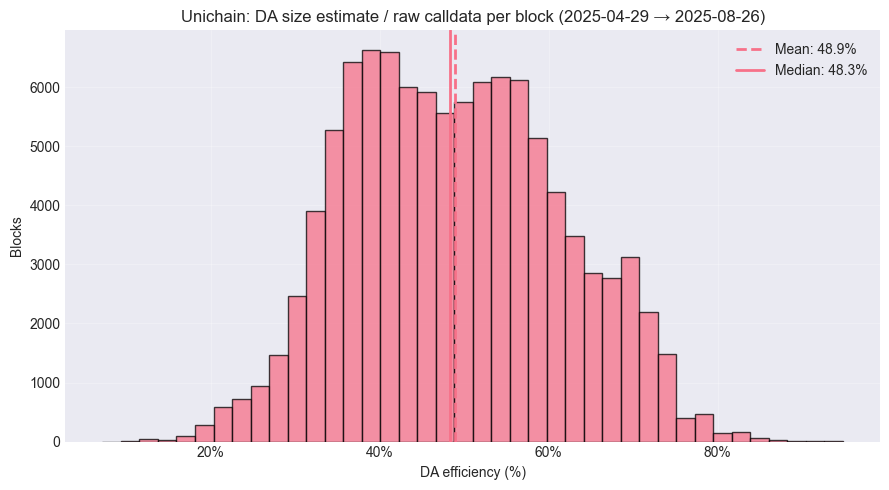

In [15]:
plot_block_metric_distribution(
    scalar_to_peek=400,
    analysis_results=analysis_results,
    metric_fn=lambda b: b.total_da_usage_estimate / (b.total_calldata_size + 100 * b.tx_count),
    title="DA size estimate / raw calldata per block",
    xlabel="DA efficiency (%)",
    percent_scale=True,
    chain_name=get_chain_display_name(CHAIN),
    start_date=START_DATE,
    end_date=END_DATE,
    min_calldata=True
)


📊 Distribution of da_usage_estimate / gas_used
   n blocks: 103,680
   mean:   50.94%
   median: 48.90%


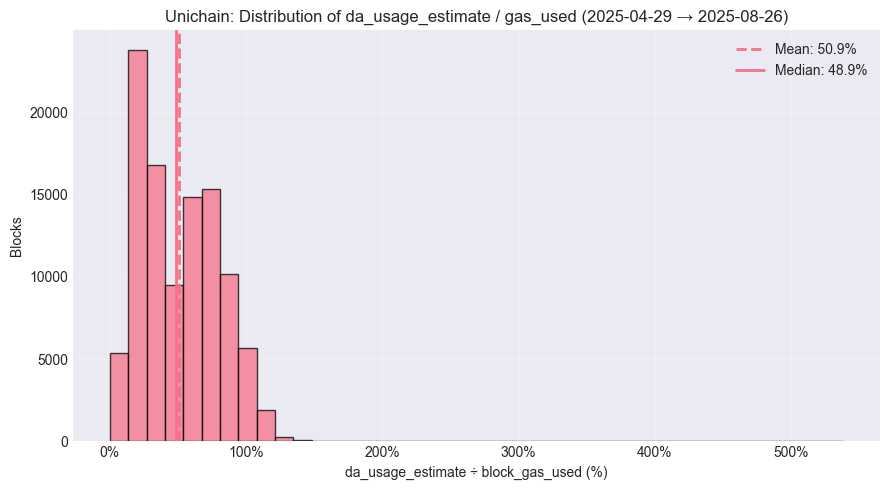

In [16]:
plot_block_metric_distribution(
    scalar_to_peek=400,
    analysis_results=analysis_results,
    metric_fn=lambda b: b.utilization_vs_gas_used,
    title="Distribution of da_usage_estimate / gas_used",
    xlabel="da_usage_estimate ÷ block_gas_used (%)",
    percent_scale=True,
    value_filter=lambda x: x is not None,
    chain_name=get_chain_display_name(CHAIN),
    start_date=START_DATE,
    end_date=END_DATE
)


📊 Distribution of DA usage / target
   n blocks: 103,680
   mean:   31.61%
   median: 29.37%


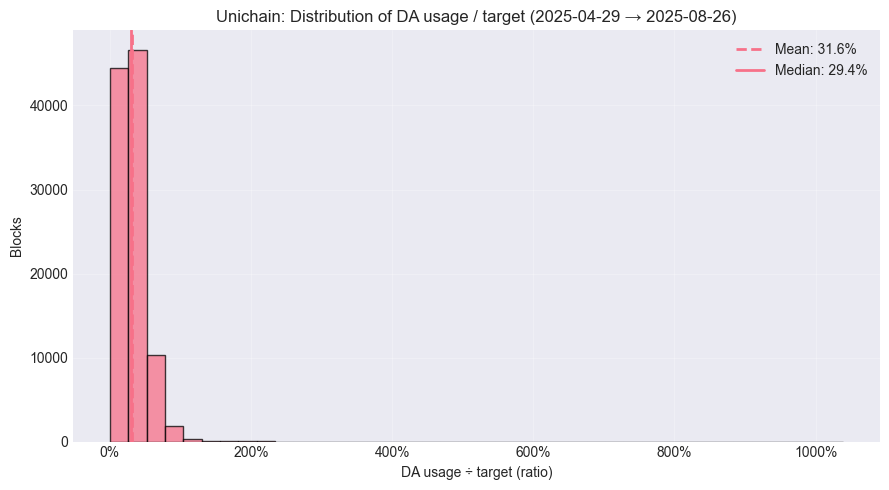

In [17]:
plot_block_metric_distribution(
    scalar_to_peek=400,
    analysis_results=analysis_results,
    metric_fn=lambda b: b.target_utilization,  
    title="Distribution of DA usage / target",
    xlabel="DA usage ÷ target (ratio)",
    percent_scale=True,  
    value_filter=lambda x: x is not None,
    chain_name=get_chain_display_name(CHAIN),
    start_date=START_DATE,
    end_date=END_DATE
)

In [18]:
def generate_analysis_markdown_table(analysis_results):
    """Corrected version using consistent gas limit for both Effective Limit and DA Usage Target."""
    headers = [
        "Scalar",
        "Effective Limit",
        "DA Usage Target",
        "Exceeding Limit",
        "Exc. Target",
        "Exc. Gas Usage",
        "Avg. Utilization",
        "Max Utilization"
    ]
    rows = []

    # Pull metadata from any analysis result
    sample_result = next(iter(analysis_results.values()))
    chain = sample_result.chain
    total_blocks = sample_result.total_blocks

    # --- Compute DA Usage stats across all scalars (only once) ---
    all_blocks = []
    for result in analysis_results.values():
        all_blocks.extend(result.block_analyses)

    da_usages = [b.total_da_usage_estimate for b in all_blocks]
    mean_da = int(round(np.mean(da_usages)))
    max_da = max(da_usages)

    for scalar in sorted(analysis_results.keys()):
        result = analysis_results[scalar]
        eff_limit = f"{result.gas_limit // scalar:,}"
        
        # Calculate DA Usage Target using the same gas limit as Effective Limit for consistency
        target_str = f"{int(result.gas_limit / (eip1559_elasticity * scalar)):,}"

        exceeding = f"{result.blocks_exceeding} ({result.percentage_exceeding:.2f}%)" if result.blocks_exceeding else "0"
        
        # Target exceeding metrics (these are already calculated in analysis_results)
        exc_target = f"{result.blocks_exceeding_target} ({result.percentage_exceeding_target:.2f}%)" if result.blocks_exceeding_target else "0"

        if getattr(result, "blocks_with_gas_used", 0) > 0:
            over_cnt_measured = int(round(result.share_over_1_vs_used * result.blocks_with_gas_used))
            exc_gas_usage = f"{over_cnt_measured} ({result.share_over_1_vs_used * 100:.1f}%)"
        else:
            exc_gas_usage = "n/a"

        avg_util = f"{result.avg_utilization * 100:.1f}%"
        max_util = f"{result.max_utilization * 100:.1f}%"

        rows.append([str(scalar), eff_limit, target_str, exceeding, exc_target, exc_gas_usage, avg_util, max_util])

    # --- Header with DA Usage summary ---
    md = f"**Chain:** `{chain}` • **Sample Size:** `{total_blocks}` blocks\n"
    md += f"**Mean DA Usage / block:** `{mean_da:,}` • **Max DA Usage / block:** `{max_da:,}`\n\n"

    # --- Markdown Table ---
    md += "| " + " | ".join(headers) + " |\n"
    md += "|-" + "-|-".join(["-" * len(h) for h in headers]) + "-|\n"
    for row in rows:
        md += "| " + " | ".join(row) + " |\n"

    return md

In [19]:
markdown_output_updated = generate_analysis_markdown_table(analysis_results)
print(markdown_output_updated)


**Chain:** `unichain` • **Sample Size:** `103680` blocks
**Mean DA Usage / block:** `3,951` • **Max DA Usage / block:** `129,900`

| Scalar | Effective Limit | DA Usage Target | Exceeding Limit | Exc. Target | Exc. Gas Usage | Avg. Utilization | Max Utilization |
|--------|-----------------|-----------------|-----------------|-------------|----------------|------------------|-----------------|
| 160 | 187,500 | 31,250 | 0 | 13 (0.01%) | 1 (0.0%) | 2.1% | 69.3% |
| 400 | 75,000 | 12,500 | 4 (0.00%) | 601 (0.58%) | 4897 (4.7%) | 5.3% | 173.2% |
| 600 | 50,000 | 8,333 | 5 (0.00%) | 4884 (4.71%) | 34185 (33.0%) | 7.9% | 259.8% |
| 800 | 37,500 | 6,250 | 9 (0.01%) | 14606 (14.09%) | 51142 (49.3%) | 10.5% | 346.4% |



In [20]:
# print the max da usage block stats
df[df["total_da_usage_estimate"] == df["total_da_usage_estimate"].max()]


,block_number,total_da_usage_estimate,tx_count
19157,23616084,129900,1299


In [21]:
!python -m nbconvert --to html jovian_analysis.ipynb --output saved_output_html/{CHAIN}_{SAMPLING_METHOD}_{START_DATE}_{END_DATE}.html

[NbConvertApp] Converting notebook jovian_analysis.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 10 image(s).
[NbConvertApp] Writing 1609230 bytes to saved_output_html/unichain_random_2025-04-29_2025-08-26.html


## Usage Instructions

### To Analyze Different Chains:
1. Change `CHAIN = "base"` to `CHAIN = "op"` (or other chains)
2. Re-run the configuration cell and all subsequent cells

### To Change Sampling Method:
1. Change `SAMPLING_METHOD = "top_percentile"` to `SAMPLING_METHOD = "random"`
2. Adjust `PERCENTILE` or `SAMPLE_FRACTION` as needed
3. Re-run the configuration cell and all subsequent cells

### To Analyze Different Date Ranges:
1. Change `START_DATE` and `END_DATE`
2. Re-run the configuration cell and all subsequent cells

### To Force Refresh Data:
1. Set `FORCE_REFRESH = True`
2. Re-run the data fetching cell

### To Save Results:
1. Set `SAVE_RESULTS = True` (default)
2. Results will be saved to `../results/{chain}/`

### To Show Plots:
1. Set `SHOW_PLOTS = True` (default)
2. Plots will be displayed inline